### Imports


In [1]:
import transformers, datasets
import numpy as np
from datasets import load_dataset
transformers.__version__, datasets.__version__

('4.39.3', '2.18.0')

### WandB for logging performance metrics


In [2]:
import os 
os.environ['WANDB_API_KEY'] = '00d7257c850e310bdf53a4abbefdef4635089557'

### Dataset

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-05-28 10:23:00--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: 'AirlineTweets.csv'

AirlineTweets.csv   100%[===================>]   3.26M  19.4MB/s    in 0.2s    

2024-05-28 10:23:01 (19.4 MB/s) - 'AirlineTweets.csv' saved [3421431/3421431]



In [4]:
import pandas as pd
df = pd.read_csv("/kaggle/working/AirlineTweets.csv")

In [5]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['label'] = df['airline_sentiment'].map(target_map)
df.rename(columns={'text': 'sentence'}, inplace=True)

In [6]:
from datasets import Dataset

raw_datasets = Dataset.from_pandas(df[["sentence", "label"]])

In [7]:
raw_datasets

Dataset({
    features: ['sentence', 'label'],
    num_rows: 14640
})

In [8]:
raw_datasets = raw_datasets.train_test_split(test_size=0.3, seed=42)

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [10]:
raw_datasets['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

### Model and Tokenizer

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# checkpoint = "bert-base-uncased"
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
!pip install torchinfo
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

In [13]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

tokenized_datasets

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

### Training Arguments

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'training_dir',
    num_train_epochs = 5,
    learning_rate = 1e-5,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_steps = 0.05,
    logging_dir="./logs",
    save_steps = 0.05,
    load_best_model_at_end = True,
    run_name= "airplane_tweet_run1",
    fp16 = False,
    save_total_limit = 3, 
    report_to="wandb")

### Trainer and performance metrics 

In [15]:
from transformers import Trainer
import torch
lang = 'eng'
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss, f1_score, confusion_matrix
from torch.nn import CrossEntropyLoss
def compute_metrics(pred):
    global num_labels
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    logits = torch.tensor(pred.predictions)
    labels = torch.tensor(labels)
    return {
        'accuracy@'+lang: acc,
        'f1@'+lang: f1,
        'precision@'+lang: precision,
        'recall@'+lang: recall,
     }



2024-05-28 10:23:24.045554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 10:23:24.045692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 10:23:24.193822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training

In [17]:
trainer.train()

wandb: Currently logged in as: gautam-taaresh. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy@eng,F1@eng,Precision@eng,Recall@eng
41,0.909700,0.808416,0.640027,0.260169,0.213342,0.333333
82,0.757200,0.618357,0.737705,0.532266,0.798161,0.573702
123,0.573300,0.505867,0.808515,0.734887,0.745763,0.736133
164,0.496200,0.469502,0.817168,0.744161,0.767915,0.730084
205,0.448100,0.456786,0.825137,0.761424,0.772856,0.752423
246,0.442900,0.449855,0.826047,0.759378,0.780150,0.745475
287,0.439600,0.445016,0.823315,0.763260,0.761943,0.767514
328,0.410400,0.441831,0.829463,0.765078,0.773649,0.764135
369,0.390000,0.438399,0.829918,0.777392,0.772701,0.782378
410,0.390400,0.436653,0.833561,0.780623,0.785261,0.776830


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=805, training_loss=0.4369335150866775, metrics={'train_runtime': 250.198, 'train_samples_per_second': 204.798, 'train_steps_per_second': 3.217, 'total_flos': 668827404370080.0, 'train_loss': 0.4369335150866775, 'epoch': 5.0})

### Inference

In [18]:
!ls "/kaggle/working/training_dir"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


checkpoint-492	checkpoint-738	checkpoint-779


In [19]:
from transformers import pipeline

savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-492',
                      device='cuda')


In [21]:
raw_datasets['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [22]:
test_pred = savedmodel(raw_datasets['test']['sentence'])


In [23]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [24]:
print("acc:", accuracy_score(raw_datasets['test']['label'], test_pred))
print("f1:", f1_score(raw_datasets['test']['label'], test_pred, average='macro'))


acc: 0.8356102003642987
f1: 0.7805508239760034


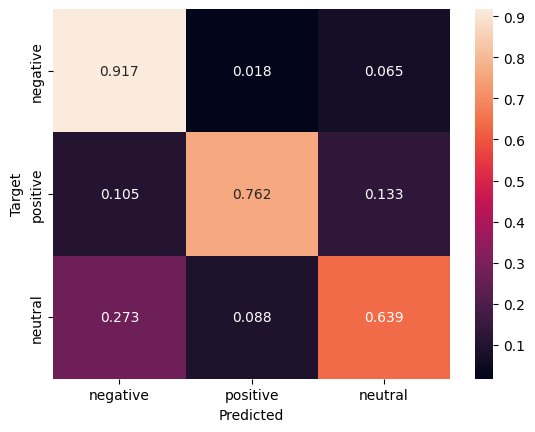

In [25]:
import seaborn as sns 
import matplotlib.pyplot as plt

cm = confusion_matrix(tokenized_datasets['test']['label'], test_pred, normalize='true')

ax= sns.heatmap(cm, annot= True, fmt = ".3f", xticklabels = ["negative", "positive","neutral"],
           yticklabels = ["negative", "positive","neutral"], )

ax.set(xlabel="Predicted", ylabel="Target")
plt.show()